In [1]:
%load_ext autoreload
%autoreload 2
import scipy
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import keras

import time

2024-05-29 14:50:29.489899: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-29 14:50:29.967660: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 14:50:29.967694: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 14:50:29.979057: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-29 14:50:29.995779: I tensorflow/core/platform/cpu_feature_guar

## Observations
At each timestep $t$, we observe $S=4$ artificial locations. The observed value $y_{s,t}$ is realization of random variable $Y_s$, which is normally distributed with unit variance and a location-specific mean: $Y_{s,t} \sim \mathcal{N}(\mu_s, 1)$. The means are $\mu = [5, 15, 25, 35]$.

In [2]:
S=4
scale = 1
means = [5.0, 15.0, 25.0, 35.0]
# simulate data for each location
data_distributions = [scipy.stats.norm(loc=mean, scale=scale) for mean in means]

In total, we observe $T=1000$ examples. We frame this as a machine learning problem and our goal is to train a model given some features $x$ to accurately predict $y$. However, we are unconcerned with learning here, and care only about our ability to calculate gradients. Here, we use $x \in \mathbb{R}^F$ as an $F=20$ dimensional feature vector, but the features are uninformative and sampled from a standard normal. 

In [3]:
T=1000
# create random state for sampling
seed=360
rng = np.random.RandomState(seed)
y_TS = np.array([dist.rvs(size=T, random_state=rng) for dist in data_distributions]).T
assert(y_TS.shape == (T, S))

F=20
# x doesn't matter because we aren't learning
x_TF = rng.standard_normal(size=(T, F))

2024-05-29 14:53:22.663998: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-29 14:53:22.664036: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: p1cmp078.pax.tufts.edu
2024-05-29 14:53:22.664043: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: p1cmp078.pax.tufts.edu
2024-05-29 14:53:22.664151: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.129.3
2024-05-29 14:53:22.664176: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.129.3
2024-05-29 14:53:22.664181: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.129.3


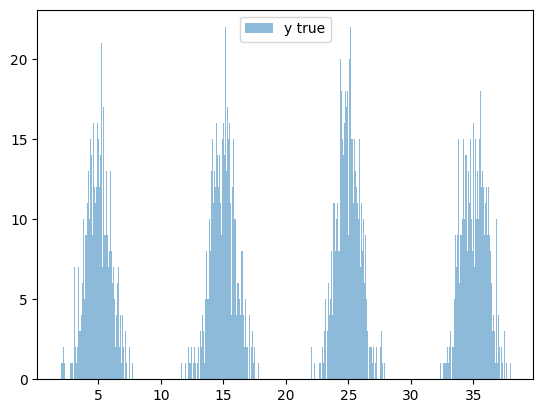

In [4]:
plt.hist(tf.reshape(y_TS, [-1]).numpy(),alpha=0.5, bins=1000, label='y true')
plt.legend()

## Model
We will model this with the true model: predictions $\hat{y}_{s,t}$ will come from S, location-specific normal distributions, where the mean is determined by a function $f_{\phi_s}(x)$ with location-specific parameters $\phi_s$, and the variance is fixed to the true value of 1.

$$p(\hat{y}_{s,t}) = \mathcal{N}(\hat{y}_{s,t}| f_{\phi_s}(x), 1)$$
All locations are independent:
$$p(\hat{y}_{t}) = \prod_{s=1}^S \mathcal{N}(\hat{y}_{s,t}| f_{\phi_s}(x), 1)$$

Our model is a simple linear model with an intercept:
$$f_{\phi_s}(x_s) = \phi_s x_s + \phi_{s,0}$$
Our model can trivially recover the true data generating process by setting the coefficient terms of $\phi_s$ to 0 and the intercept to the true mean $\phi_{s,0} = \mu_s$

## Objective
We will use our model's predictions $\hat{y}$ in order to choose some action $\theta$, which can be calculated by a deterministic but not necessarily differentiable function $a$ of $\hat{y}$:
$$\theta_t = a(\hat{y}_t)$$

Given a decision $\theta$, we can calculate a loss between our action and the observed outcome $\mathcal{L}(\theta_t, y_t)$. Our goal is to calculate gradients of that loss with respect to our model parameters. We can use the chain rule to decompose the gradient into two parts:
$$ \nabla_\phi \mathcal{L}(\theta_t, y_t) = \nabla_\phi \theta \nabla_\theta  \mathcal{L}(\theta_t, y_t)$$

When $\theta$ is non-differentiable, we can obtain gradients using the score-function trick, where we can approximate the gradient using $M$ samples from our probabilistic model $p$
$$\nabla_\phi \theta = \frac{1}{M} \sum_{m=1}^M \nabla_\phi \log p(y^m) a(y)$$

Our loss is mean-squared error and easy to differentiate: 
$$\mathcal{L} (\theta_t, y_t) = \frac{1}{S}\sum_{s=1}^S(y_t-\theta_t)^2$$

## Implementing the model

In [5]:
inputs = keras.Input(shape=F)
linear_layer = keras.layers.Dense(S, activation = None)
distribution_layer = tfp.layers.DistributionLambda(lambda t: tfp.distributions.Normal(loc=t, scale=1))

In [6]:
predicted_means = linear_layer(inputs)
distributions = distribution_layer(predicted_means)
model = keras.Model(inputs=inputs, outputs=distributions)

In [7]:
model_distributions = model(x_TF)
print(f'Model parameter shapes: {[w.shape for w in model.get_weights()]}')

Model parameter shapes: [(20, 4), (4,)]


### Set weights to true values
We'll set the linear coefficients to 0 and the biases to the true means

In [8]:
linear_weights = model.trainable_variables[0]
linear_weights.assign(tf.zeros_like(linear_weights))

biases = model.trainable_variables[1]
biases.assign(means)

print(f'Max linear weight magnitude {tf.reduce_max(tf.abs(model.trainable_variables[0]))}')
print(f'Biases {model.get_weights()[1]}')

Max linear weight magnitude 0.0
Biases [ 5. 15. 25. 35.]


In [9]:
M=500
model_distributions = model(x_TF)
sample_y_MTS = model_distributions.sample(M)
assert(sample_y_MTS.shape == (M, T, S))

sample_log_probs_MTS = model_distributions.log_prob(sample_y_MTS)
sample_actions_MTS = tf.identity(sample_y_MTS)
expected_actions_TS = tf.reduce_mean(sample_actions_MTS, axis=0)
loss_T = keras.losses.mean_squared_error(y_TS, expected_actions_TS)
loss = tf.reduce_mean(loss_T)

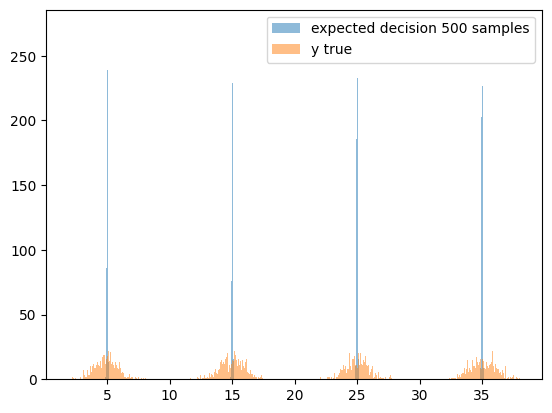

In [10]:
plt.hist(tf.reshape(expected_actions_TS, [-1]).numpy(),alpha=0.5, bins=1000, label=f'expected decision {M} samples')
plt.hist(tf.reshape(y_TS, [-1]).numpy(),alpha=0.5, bins=1000, label='y true')
plt.legend()

## Implement the score function trick


In [11]:
def score_function_trick(jacobian_MTSp, actions_MTS):
    """Implement score function trick
    
    Args:
    jacobian_MTSp: Gradient of the log probability of the samples of y given model parameter p
        tf.Tensor of shape (M, T, S, p), where p is the shape of the parameter
    actions_MTS: Action taken at each sampple
    """
    # Solve for the rank of the parameter by subtracting the sample/time/location dimension
    rank_P = tf.rank(jacobian_MTSp)-3
    # add new size 1 dimensions so that the action broadcasts to the shape of the parameter
    new_shape = tf.concat([tf.shape(actions_MTS), tf.ones([rank_P], tf.int32)], axis=0)
    actions_MTSp = tf.reshape(actions_MTS, new_shape)

    scaled_jacobian_MTSp = jacobian_MTSp*actions_MTSp

    # average over sample dims
    param_gradient_BSp = tf.reduce_mean(scaled_jacobian_MTSp, axis=0)

    return param_gradient_BSp

def overall_gradient_calculation(gradient_TSp, action_gradient_TS):
    """Calculate final loss gradeint
    
    Args:
    gradient_BSp: Of the action w.r.t to parameter p
        tf.Tensor of shape (M, T, S, p), where p is the shape of the parameter
    action_gradient_TS: Gradient of loss w.r.t. to action
    """
    # Solve for the rank of the parameter by subtracting the time/location dimension
    rank_P = tf.rank(gradient_TSp)-2
    # add new size 1 dimensions so that the action broadcasts to the shape of the parameter
    new_shape = tf.concat([tf.shape(action_gradient_TS), tf.ones([rank_P], tf.int32)], axis=0)
    action_gradient_TSp = tf.reshape(action_gradient_TS, new_shape)

    overall_gradient_TSp = gradient_TSp*action_gradient_TSp

    # Sum over spatial dimensions
    overall_gradient_Tp = tf.reduce_sum(overall_gradient_TSp, axis=1)
    # average over time
    overall_gradient_p = tf.reduce_mean(overall_gradient_Tp, axis=0)

    return overall_gradient_p

### Differentiate the score function trick
We'll take $M=5$ samples, and use the identity function as our action $a(y)=y$

$$ \nabla_\phi \mathcal{L}(\theta_t, y_t) = \nabla_\phi \theta \nabla_\theta  \mathcal{L}(\theta_t, y_t)$$

When $\theta$ is non-differentiable, we can obtain gradients using the score-function trick, where we can approximate the gradient using $M$ samples from our probabilistic model $p$
$$\nabla_\phi \theta = \frac{1}{M} \sum_{m=1}^M \nabla_\phi \log p(y^m) a(y)$$

Our loss is mean-squared error and easy to differentiate: 
$$\mathcal{L} (\theta_t, y_t) = \frac{1}{S}\sum_{s=1}^S(y_t-\theta_t)^2$$

$$\nabla_\phi \log p(y^m) = \nabla_\phi \left( -\log (\sigma) - \frac{1}{2}\log (2\pi) - \frac{1}{2}(\frac{y^m-\phi_\mu}{\sigma})^2 \right)$$

$$ \nabla_\phi \log p(y^m) = \frac{y^m-\phi_\mu}{\sigma^2} = y^m -\phi_\mu$$

$$\nabla_\phi \theta = \frac{1}{M} \sum_{m=1}^M (y^m - \phi_\mu) a(y)$$

 $$\nabla_\theta  \mathcal{L}(\theta_t, y_t) =  \nabla_\theta   \frac{1}{S}\sum_{s=1}^S(y_t-\theta_t)^2$$

$$ = \frac{1}{S}\sum_{s=1}^S-2(y_t-\theta_t)$$

In [11]:
M=3
model_distributions = model(x_TF)
sample_y_MTS = model_distributions.sample(M)
grad_theta_wrt_phi_TS = tf.reduce_mean((sample_y_MTS - model.trainable_variables[1])*sample_y_MTS, axis=0)

sample_actions_MTS = tf.identity(sample_y_MTS)
expected_actions_TS = tf.reduce_mean(sample_actions_MTS, axis=0)
loss_T = keras.losses.mean_squared_error(y_TS, expected_actions_TS)
loss = tf.reduce_mean(loss_T)
grad_L_wrt_theta_TS = -2.0*(y_TS-expected_actions_TS)

analytical_gradient_TS = grad_theta_wrt_phi_TS*grad_L_wrt_theta_TS

In [44]:
grad_theta_wrt_phi_TS

<tf.Tensor: shape=(1000, 4), dtype=float32, numpy=
array([[  6.4703164 ,   3.0037193 , -12.423985  ,  12.632436  ],
       [  1.0286243 ,  10.645972  ,   8.992711  ,  -8.953015  ],
       [  0.47499323,   3.5912526 ,   0.31085506,  11.354911  ],
       ...,
       [  0.6432822 ,  18.98562   ,   1.1854235 , -48.1167    ],
       [ -3.010149  ,   1.1026604 , -10.8927355 ,   1.0519905 ],
       [  2.9530306 ,  24.70825   ,  -5.360645  ,   8.956947  ]],
      dtype=float32)>

In [26]:

M=1000
model.trainable_variables[1].assign([5,15,20,35])

analytical_grads, autodiff_grads, losses, param_vals = [], [], [], []


for param_value in np.linspace(20, 30, 10, dtype=np.float32):
    print(param_value)
    mean_param = [5, 15, param_value, 35]
    variable = model.trainable_variables[1]
    variable.assign(mean_param)

    start = time.time()

    for trial in range(10):
        with tf.GradientTape() as master_tape:
            model_distributions = model(x_TF)
            sample_y_MTS = model_distributions.sample(M)
            stopped_samples_MTS = tf.stop_gradient(sample_y_MTS)
            sample_log_probs_MTS = model_distributions.log_prob(stopped_samples_MTS)
            grad_theta_wrt_phi_TS = tf.reduce_mean((sample_y_MTS - model.trainable_variables[1])*sample_y_MTS, axis=0)

            sample_actions_MTS = tf.identity(sample_y_MTS)
            expected_actions_TS = tf.reduce_mean(sample_actions_MTS, axis=0)
            loss_T = keras.losses.mean_squared_error(y_TS, expected_actions_TS)
            loss = tf.reduce_mean(loss_T)
            grad_L_wrt_theta_TS = -2.0/S*(y_TS-expected_actions_TS)

        analytical_gradient_TS = grad_theta_wrt_phi_TS*grad_L_wrt_theta_TS
        master_gradient = master_tape.gradient(loss_T, model.trainable_weights)
        autodiff_grads.append(master_gradient[1][2])
        losses.append(loss)
        analytical_grads.append(tf.reduce_mean(analytical_gradient_TS, axis=0)[2])
        param_vals.append(param_value)
    end = time.time()
    elapsed = end - start
    print(f'Elapsed time {elapsed}')

20.0
Elapsed time 1.4972538948059082
21.11111
Elapsed time 0.9639532566070557
22.222221
Elapsed time 1.0603528022766113
23.333334
Elapsed time 0.9575560092926025
24.444445
Elapsed time 1.3297183513641357
25.555555
Elapsed time 1.4016408920288086
26.666666
Elapsed time 0.9499857425689697
27.777779
Elapsed time 0.9454221725463867
28.88889
Elapsed time 0.9447081089019775
30.0
Elapsed time 1.0112807750701904


In [16]:
def plot_results(analytical_grads, autodiff_grads, losses, param_vals, T):
    # plot with 2 different scales, 1 y axis for each graph:
    fig, ax1 = plt.subplots()

    # Plot the first line on ax1
    ax1.set_xlabel('3rd cluster mean')
    ax1.set_ylabel('loss')
    ax1.plot(param_vals, losses, label='loss')
    ax1.tick_params(axis='y')
    ax1.set_ylim([-10, 10])
    plt.legend()
    # Create ax2, which shares the same x-axis as ax1
    ax2 = ax1.twinx()
    ax2.set_ylabel('gradient')
    # divide by 1000 because autodiff is summing over samples
    ax2.plot(param_vals, [mag/T for mag in autodiff_grads], 'g-', label='autodiff gradient')
    ax2.plot(param_vals, analytical_grads,'k*',label='score func gradient', )
    ax2.tick_params(axis='y')
    #ax2.set_ylim([-10,10])

    #ax2.set_ylim([-1000, 1000])
    #plot vertical line at x=25
    plt.axvline(x=25, color='r', linestyle='--', label='true mean')
    plt.axhline(y=0, color='r', linestyle=':', label='0 gradient')
    fig.tight_layout()
    plt.legend()

    plt.title(f'Loss and6 gradients score_func samples M={M}')
    plt.show()


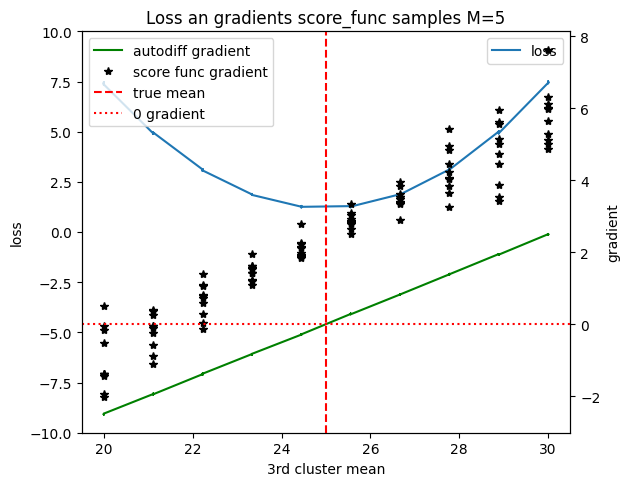

In [19]:
plot_results(analytical_grads, autodiff_grads, losses, param_vals, T)

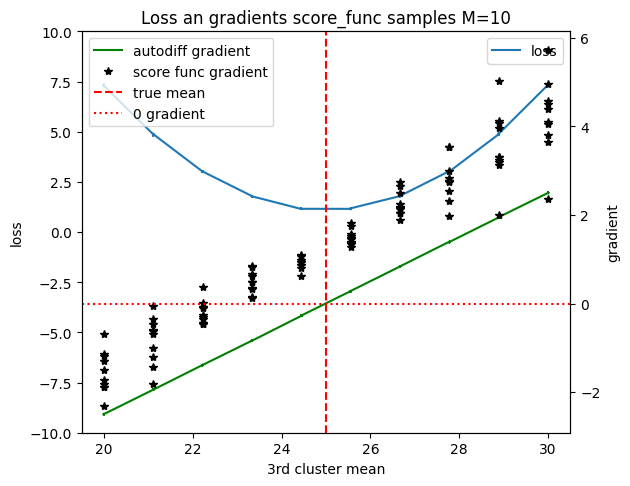

In [21]:
plot_results(analytical_grads, autodiff_grads, losses, param_vals, T)

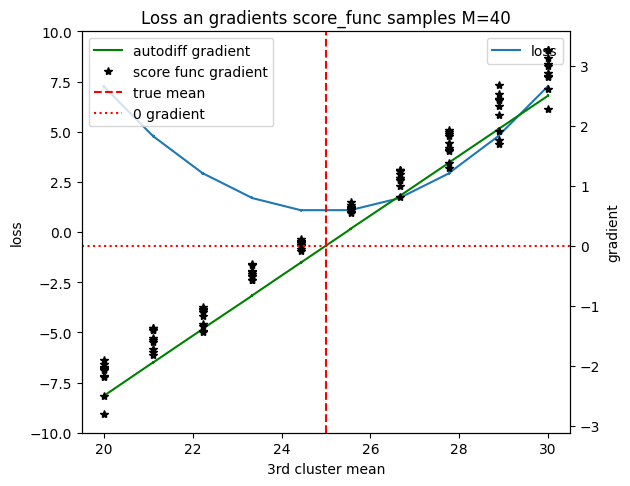

In [23]:
plot_results(analytical_grads, autodiff_grads, losses, param_vals, T)

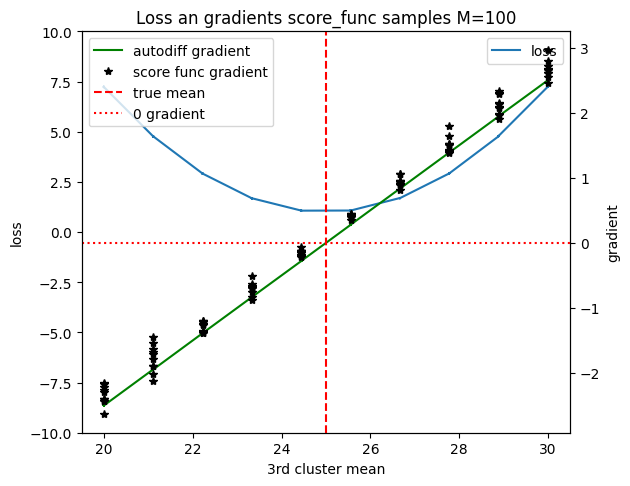

In [25]:
plot_results(analytical_grads, autodiff_grads, losses, param_vals, T)

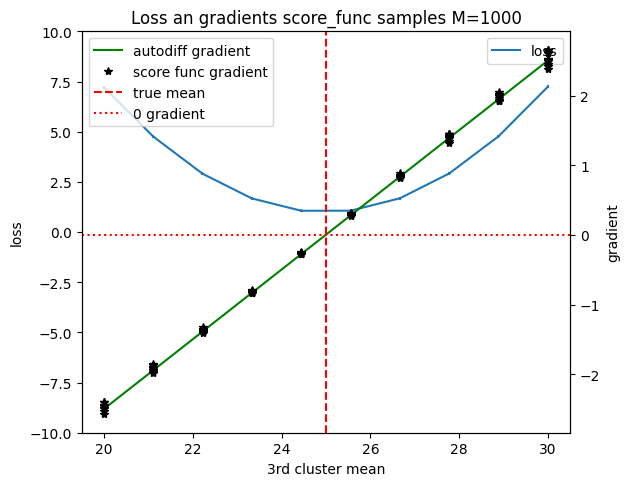

In [27]:
plot_results(analytical_grads, autodiff_grads, losses, param_vals, T)